In [1]:
import pandas as pd
import numpy as np

# helpers
from helpers import evaluate_test

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Wisienka na koniec
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

# Warnings will not pass!
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

### Importing data and initial look into it

In [2]:
train_data = pd.read_csv('data/train_data.csv')
test_features = pd.read_csv('data/test_features.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             52500 non-null  int64  
 1   age            52500 non-null  int64  
 2   gender         50955 non-null  object 
 3   height         51464 non-null  float64
 4   weight         50434 non-null  float64
 5   ap_hi          52500 non-null  int64  
 6   ap_lo          52500 non-null  int64  
 7   cholesterol    52500 non-null  object 
 8   gluc           52500 non-null  object 
 9   lifestyle      43143 non-null  object 
 10  is_cardio_ill  52500 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 4.4+ MB


In [4]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123 entries, 0 to 17122
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           17123 non-null  int64  
 1   age          17123 non-null  int64  
 2   gender       17123 non-null  object 
 3   height       17123 non-null  int64  
 4   weight       17123 non-null  float64
 5   ap_hi        17123 non-null  int64  
 6   ap_lo        17123 non-null  int64  
 7   cholesterol  17123 non-null  object 
 8   gluc         17123 non-null  object 
 9   lifestyle    14104 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 1.3+ MB


In [5]:
train_data.drop('id', axis=1, inplace=True)

### Random submission

In [6]:
# Everyone is sick
test_labels.value_counts()
preds = np.ones(len(test_labels))

acc = accuracy_score(test_labels, preds)
if acc < 0.5:
    preds = np.zeros(len(test_labels))
    acc = accuracy_score(test_labels, preds)
print(f"Dumb model accuracy: {np.round(100 * acc, 3)}%")

Dumb model accuracy: 50.71%


### Splitting datasets - why the heck do we need this?

In [7]:
train_X, val_X, train_y, val_y = train_test_split(
    train_data.drop("is_cardio_ill", axis=1),
    train_data['is_cardio_ill'],
    test_size=0.3,
    random_state=42
)

### Baseline train

1. Problem with categorical features
2. Problem with missing values

In [8]:
# categorical features - just remove them
train_X_dumb = train_X.drop(['gender', 'cholesterol', 'gluc', 'lifestyle'], axis=1)
val_X_dumb = val_X.drop(['gender', 'cholesterol', 'gluc', 'lifestyle'], axis=1)

test_X_dumb = test_features.drop(['id', 'gender', 'cholesterol', 'gluc', 'lifestyle'], axis=1)

# Missing values - drop records
train_X_dumb.dropna(inplace=True)
train_y_dumb = train_y.loc[train_X_dumb.index]

val_X_dumb.dropna(inplace=True)
val_y_dumb = val_y.loc[val_X_dumb.index]

def evaluate_model(train_X, train_y, val_X, val_y, test_X, model_name=""):
    
    assert len(train_X) == len(train_y), "Lengths in the train set mismatch"
    assert len(val_X) == len(val_y), "Lengths in the validation set mismatch"
    assert train_X.shape[1] == val_X.shape[1], "Numbers of features in train and val sets mismatch"
    assert train_X.shape[1] == test_X.shape[1], "Numbers of features in train and test sets mismatch"
    
    model = LogisticRegression()
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    preds_test = model.predict(test_X)
    
    acc_val = accuracy_score(val_y, preds_val)
    print(f"{model_name} Model val accuracy: {round(100 * acc_val, 2)}%")
    
    acc_test = evaluate_test(preds_test)
    print(f"{model_name} Model test accuracy: {round(100 * acc_test, 2)}%")
    
evaluate_model(train_X_dumb, train_y_dumb, val_X_dumb, val_y_dumb, test_X_dumb, model_name="Baseline")
# train_X_dumb.shape

Baseline Model val accuracy: 69.5%
Baseline Model test accuracy: 69.38%


### Not bad, but can we do better?

<img src="https://i.pinimg.com/736x/a8/ef/58/a8ef58e480da3676dc81f0ffc191807b--swimmer-girl-problems-jeep-humor.jpg" width=400 height=400 />

Src: https://i.pinimg.com/736x/a8/ef/58/a8ef58e480da3676dc81f0ffc191807b--swimmer-girl-problems-jeep-humor.jpg

### Sklearn - not only for learning

In [9]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV

### TODO: Imputation

In [10]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36750 entries, 17904 to 15795
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          36750 non-null  int64  
 1   gender       35644 non-null  object 
 2   height       36023 non-null  float64
 3   weight       35292 non-null  float64
 4   ap_hi        36750 non-null  int64  
 5   ap_lo        36750 non-null  int64  
 6   cholesterol  36750 non-null  object 
 7   gluc         36750 non-null  object 
 8   lifestyle    30232 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 2.8+ MB


Text(0.5, 0, 'weight')

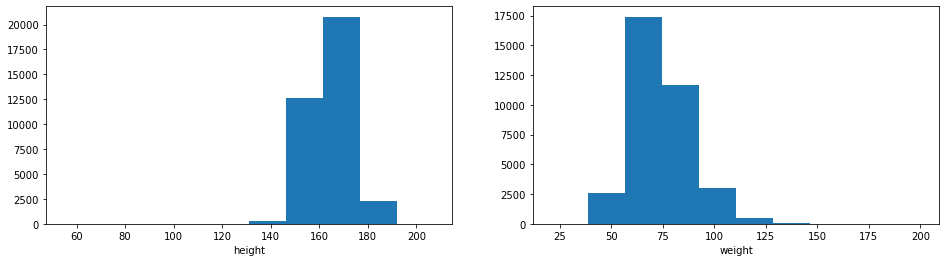

In [11]:
plt.rcParams['figure.figsize'] = 16, 4
fig, (ax0, ax1)= plt.subplots(1, 2)
ax0.hist(train_X['height'])
ax0.set_xlabel('height')
ax1.hist(train_X['weight'])
ax1.set_xlabel('weight')

#### Numerical Imputation

<a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute">SimpleImputer</a>

In [12]:
strategies = ['most_frequent', 'mean', 'median']

for strategy in strategies:
    
    print(f'\n Results using strategy {strategy}')
    train_X_num = train_X.drop(['gender', 'cholesterol', 'gluc', 'lifestyle'], axis=1)
    val_X_num = val_X.drop(['gender', 'cholesterol', 'gluc', 'lifestyle'], axis=1)

    test_X_num = test_features.drop(['id', 'gender', 'cholesterol', 'gluc', 'lifestyle'], axis=1)
    
    imputer_num = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer_num.fit(train_X[['height', 'weight']])

    transformed_train = imputer_num.transform(train_X[['height', 'weight']])
    train_X_num[['height', 'weight']] = transformed_train

    transformed_val = imputer_num.transform(val_X[['height', 'weight']])
    val_X_num[['height', 'weight']] = transformed_val

    transformed_test = imputer_num.transform(test_features[['height', 'weight']])
    test_X_num[['height', 'weight']] = transformed_test

    evaluate_model(train_X_num, train_y, val_X_num, val_y, test_X_num)

# print(transformed_cols)
# print(train_X[['height', 'weight']])


 Results using strategy most_frequent
 Model val accuracy: 69.52%
 Model test accuracy: 69.48%

 Results using strategy mean
 Model val accuracy: 69.53%
 Model test accuracy: 69.49%

 Results using strategy median
 Model val accuracy: 69.5%
 Model test accuracy: 69.51%


### Categorical imputation

In [13]:
train_X.gender.value_counts()

female    23145
male      12499
Name: gender, dtype: int64

In [14]:
train_X.lifestyle.value_counts()

active                     25966
smoker,active               1893
alcoholic,active             846
smoker,alcoholic,active      829
smoker                       377
smoker,alcoholic             162
alcoholic                    159
Name: lifestyle, dtype: int64

### Common sence cleaning

In [15]:
# train_X = train_X['ap_hi']
print(f"Minimal High pressure is: {train_X_num.ap_hi.min()}")
print(f"Maximum High pressure is : {train_X_num.ap_hi.max()}")

print(f"Minimal Low pressure is: {train_X_num.ap_lo.min()}")
print(f"Maximal Low pressure is: {train_X_num.ap_lo.max()}")


Minimal High pressure is: -120
Maximum High pressure is : 16020
Minimal Low pressure is: -70
Maximal Low pressure is: 10000


<AxesSubplot:>

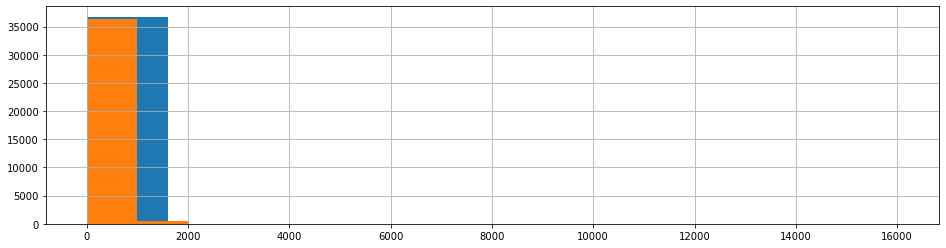

In [16]:
train_X_num['ap_hi'] = np.abs(train_X['ap_hi'])
train_X_num['ap_lo'] = np.abs(train_X['ap_lo'])

train_X_num['ap_hi'].hist()
train_X_num['ap_lo'].hist()

<AxesSubplot:>

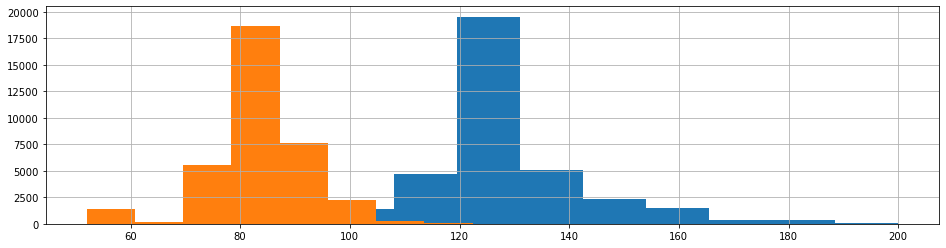

In [17]:
MAX_SYST = 210
MAX_DIAST = 150
MIN_SYST = 80
MIN_DIAST = 50

train_X_num = train_X_num[(train_X_num['ap_hi'] < MAX_SYST) & (train_X_num['ap_hi'] > MIN_SYST)]
train_X_num = train_X_num[(train_X_num['ap_lo'] < MAX_DIAST) & (train_X_num['ap_lo'] > MIN_DIAST)]
train_y_num = train_y[train_X_num.index]

train_X_num['ap_hi'].hist()
train_X_num['ap_lo'].hist()

<AxesSubplot:>

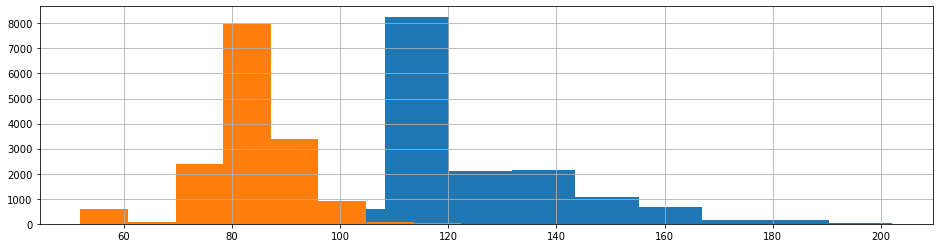

In [18]:
### Repeat for validation set
val_X_num['ap_hi'] = np.abs(val_X_num['ap_hi'])
val_X_num['ap_lo'] = np.abs(val_X_num['ap_lo'])

val_X_num = val_X_num[(val_X_num['ap_hi'] < MAX_SYST) & (val_X_num['ap_hi'] > MIN_SYST)]
val_X_num = val_X_num[(val_X_num['ap_lo'] < MAX_DIAST) & (val_X_num['ap_lo'] > MIN_DIAST)]
val_y_num = val_y[val_X_num.index]

val_X_num['ap_hi'].hist()
val_X_num['ap_lo'].hist()

#### Let's train

In [19]:
evaluate_model(train_X_num, train_y_num, val_X_num, val_y_num, test_X_num)

 Model val accuracy: 70.14%
 Model test accuracy: 70.13%


### Categorical features - encoding

In [20]:
train_X

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,lifestyle
17904,17366,male,176.0,73.0,100,70,normal,normal,active
42671,16534,female,153.0,60.0,120,70,normal,normal,active
30389,23265,male,173.0,73.0,160,100,normal,normal,active
14423,21789,female,175.0,70.0,120,80,normal,normal,active
31424,19439,male,169.0,53.0,140,90,normal,normal,active
...,...,...,...,...,...,...,...,...,...
11284,22817,female,168.0,85.0,130,80,way above normal,way above normal,active
44732,19794,female,157.0,80.0,120,80,normal,normal,active
38158,19879,female,150.0,80.0,140,80,normal,normal,active
860,21158,male,168.0,83.0,110,70,way above normal,normal,active


In [21]:
train_X_cat = train_X.loc[train_X_num.index, ['gender', 'cholesterol', 'gluc', 'lifestyle']]
val_X_cat = val_X.loc[val_X_num.index, ['gender', 'cholesterol', 'gluc', 'lifestyle']]
test_X_cat = test_features.loc[test_X_num.index, ['gender', 'cholesterol', 'gluc', 'lifestyle']]

#### TODO: Ordinal encoding

In [22]:
print(f"Train cholesterol: {train_X_cat['cholesterol'].unique()}")
print(f"Train glucose: {train_X_cat['gluc'].unique()}")

print(f"\nVal cholesterol: {val_X_cat['cholesterol'].unique()}")
print(f"Val glucose: {val_X_cat['gluc'].unique()}")

print(f"\nTest cholesterol: {test_X_cat['cholesterol'].unique()}")
print(f"Test glucose: {train_X_cat['gluc'].unique()}")

Train cholesterol: ['normal' 'way above normal' 'above normal']
Train glucose: ['normal' 'way above normal' 'above normal']

Val cholesterol: ['normal' 'above normal' 'way above normal']
Val glucose: ['normal' 'above normal' 'way above normal']

Test cholesterol: ['above normal' 'normal' 'way above normal']
Test glucose: ['normal' 'way above normal' 'above normal']


In [23]:
oe = OrdinalEncoder([['normal', 'above normal', 'way above normal'], ['normal', 'above normal', 'way above normal']])

oe.fit(train_X_cat[['cholesterol', 'gluc']])

ord_encoded_train = oe.transform(train_X_cat[['cholesterol', 'gluc']])
train_X_cat[['cholesterol', 'gluc']] = ord_encoded_train

ord_encoded_val = oe.transform(val_X_cat[['cholesterol', 'gluc']])
val_X_cat[['cholesterol', 'gluc']] = ord_encoded_val

ord_encoded_test = oe.transform(test_X_cat[['cholesterol', 'gluc']])
test_X_cat[['cholesterol', 'gluc']] = ord_encoded_test

In [24]:
train_X_cat

,gender,cholesterol,gluc,lifestyle
17904,male,0.0,0.0,active
42671,female,0.0,0.0,active
30389,male,0.0,0.0,active
14423,female,0.0,0.0,active
31424,male,0.0,0.0,active
...,...,...,...,...
11284,female,2.0,2.0,active
44732,female,0.0,0.0,active
38158,female,0.0,0.0,active
860,male,2.0,0.0,active


#### TODO: One Hot Encoding

In [25]:
### Missing values are handled
pd.get_dummies(train_X_cat.gender).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35972 entries, 17904 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   female  35972 non-null  uint8
 1   male    35972 non-null  uint8
dtypes: uint8(2)
memory usage: 351.3 KB


In [26]:
train_X_cat[['female', 'male']] = pd.get_dummies(train_X_cat.gender)
val_X_cat[['female', 'male']] = pd.get_dummies(val_X_cat.gender)
test_X_cat[['female', 'male']] = pd.get_dummies(test_X_cat.gender)

In [27]:
train_X_cat.drop('gender', axis=1, inplace=True)
val_X_cat.drop('gender', axis=1, inplace=True)
test_X_cat.drop('gender', axis=1, inplace=True)

#### Custom function

In [28]:
def encode_lifestyle(lifestyle_row) -> dict:
    
    lifestyle_dict = {
        "active": 0,
        "smoker": 0,
        "alcohol_consumer": 0
    }
    
    if lifestyle_row is not np.nan:
        values = lifestyle_row.split(',')

        if 'active' in values:
            lifestyle_dict['active'] = 1

        if 'smoker' in values:
            lifestyle_dict['smoker'] = 1

        if 'alcoholic' in values:
            lifestyle_dict['alcohol_consumer'] = 1
    
    return lifestyle_dict

In [29]:
dicts_train = train_X_cat.lifestyle.apply(encode_lifestyle)
lifestyle_df_train = pd.DataFrame(list(dicts_train.values), index=dicts_train.index)
train_X_cat.drop('lifestyle', axis=1, inplace=True)
train_X_cat = pd.concat([train_X_cat, lifestyle_df_train], axis=1)

# the same for validation
dicts_val = val_X_cat.lifestyle.apply(encode_lifestyle)
lifestyle_df_val = pd.DataFrame(list(dicts_val.values), index=dicts_val.index)
val_X_cat.drop('lifestyle', axis=1, inplace=True)
val_X_cat = pd.concat([val_X_cat, lifestyle_df_val], axis=1)

# the same for test
dicts_test = test_X_cat.lifestyle.apply(encode_lifestyle)
lifestyle_df_test = pd.DataFrame(list(dicts_test.values), index=dicts_test.index)
test_X_cat.drop('lifestyle', axis=1, inplace=True)
test_X_cat = pd.concat([test_X_cat, lifestyle_df_test], axis=1)


### Let's put together all of the data

In [30]:
new_train_X = pd.concat([train_X_num, train_X_cat], axis=1)
new_val_X = pd.concat([val_X_num, val_X_cat], axis=1)
new_test_X = pd.concat([test_X_num, test_X_cat], axis=1)

new_train_y = train_y[new_train_X.index]
new_val_y = val_y[new_val_X.index]

In [31]:
new_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35972 entries, 17904 to 15795
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               35972 non-null  int64  
 1   height            35972 non-null  float64
 2   weight            35972 non-null  float64
 3   ap_hi             35972 non-null  int64  
 4   ap_lo             35972 non-null  int64  
 5   cholesterol       35972 non-null  float64
 6   gluc              35972 non-null  float64
 7   female            35972 non-null  uint8  
 8   male              35972 non-null  uint8  
 9   active            35972 non-null  int64  
 10  smoker            35972 non-null  int64  
 11  alcohol_consumer  35972 non-null  int64  
dtypes: float64(4), int64(6), uint8(2)
memory usage: 3.1 MB


#### Training?

In [32]:
evaluate_model(new_train_X, new_train_y, new_val_X, new_val_y, new_test_X)

 Model val accuracy: 70.1%
 Model test accuracy: 70.13%


### Maybe some feature engineering?

In [33]:
new_train_X['pressure_diff'] = new_train_X['ap_hi'] - new_train_X['ap_lo']
new_val_X['pressure_diff'] = new_val_X['ap_hi'] - new_val_X['ap_lo']
new_test_X['pressure_diff'] = new_test_X['ap_hi'] - new_test_X['ap_lo']

In [34]:
evaluate_model(new_train_X, new_train_y, new_val_X, new_val_y, new_test_X)

 Model val accuracy: 70.3%
 Model test accuracy: 70.26%


### Scaling

In [36]:
min_max = MinMaxScaler()
min_max.fit(new_train_X)

new_train_X_sc = pd.DataFrame(min_max.transform(new_train_X), columns=new_train_X.columns)
new_val_X_sc = pd.DataFrame(min_max.transform(new_val_X), columns=new_val_X.columns)
new_test_X_sc = pd.DataFrame(min_max.transform(new_test_X), columns=new_test_X.columns)

In [37]:
evaluate_model(new_train_X_sc, new_train_y, new_val_X_sc, new_val_y, new_test_X_sc)

 Model val accuracy: 72.76%
 Model test accuracy: 72.58%


## We need to step back

![](https://media.giphy.com/media/KcQ7MHtLbgqDD1w5UR/giphy.gif)

### Cross validation and hyperparameter tuning on Random Forest Classifier
Since LogisticRegression doesn't give you much hyperparameters to tune.

In [38]:
all_data_X = pd.concat([new_train_X_sc, new_val_X_sc])
all_data_y = pd.concat([new_train_y, new_val_y])

In [39]:
log_reg_model = LogisticRegression()
cross_values = cross_validate(log_reg_model, X=all_data_X, y=all_data_y, cv=5)
print(f"{round(100 * cross_values['test_score'].mean(), 2)}%")

72.77%


### Chosing hyperparams using cross validation

#### RandomForest - initial look

In [40]:
rf_model = RandomForestClassifier(n_estimators=11, max_depth=7, min_samples_leaf=5, random_state=0)
cross_values_rf = cross_validate(rf_model, all_data_X, all_data_y, cv=5)
print(f"{round(100 * cross_values_rf['test_score'].mean(), 2)}%")

72.9%


### Searching for optimal hyperparameters

#### IMPORTANT! Can train A LOT of time

#### Grid Search CV

In [44]:
from tqdm import tqdm
rf_model = RandomForestClassifier()
parameters = {
    "n_estimators": [3, 5, 9, 11, 21],
    "max_depth": [2, 3, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 5, 10]
}

clf = GridSearchCV(estimator=rf_model, param_grid=parameters, verbose=True, n_jobs=3)
tqdm(clf.fit(all_data_X, all_data_y))

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


0it [00:00, ?it/s]

In [45]:
best_grid = clf.best_estimator_

In [52]:
preds_test = best_grid.predict(new_test_X_sc)
acc_test = evaluate_test(preds_test)
print(f"Best GS accuracy on test: {round(100 * acc_test, 3)}%")

Best GS accuracy on test: 73.077%


#### TODO: Random Search CV

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'ap_hi'}>],
       [<AxesSubplot:title={'center':'ap_lo'}>,
        <AxesSubplot:title={'center':'cholesterol'}>,
        <AxesSubplot:title={'center':'gluc'}>,
        <AxesSubplot:title={'center':'female'}>],
       [<AxesSubplot:title={'center':'male'}>,
        <AxesSubplot:title={'center':'active'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'alcohol_consumer'}>],
       [<AxesSubplot:title={'center':'pressure_diff'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

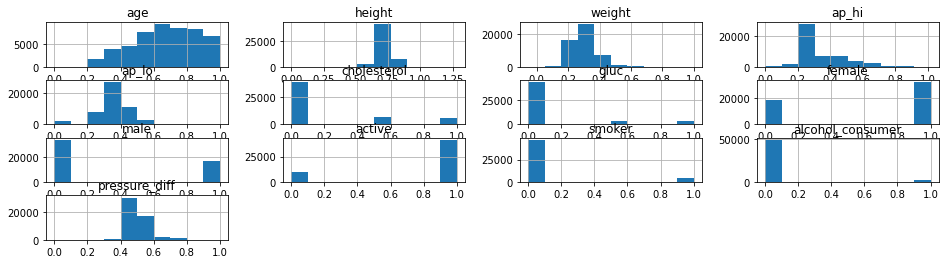

In [55]:
all_data_X.hist()

In [58]:
rf_model = RandomForestClassifier()
params_distr = {
    "n_estimators": [3, 5, 9, 11, 21],
    "max_depth": [2, 3, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 5, 10]
}

clf = RandomizedSearchCV(estimator=rf_model, param_distributions=params_distr, verbose=True, n_jobs=3)
clf.fit(all_data_X, all_data_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=3,
                   param_distributions={'max_depth': [2, 3, 5, 10, 15],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [3, 5, 9, 11, 21]},
                   verbose=True)

In [59]:
best_random = clf.best_estimator_

### Final accuracy on the test data

In [62]:
preds_test_gs = best_grid.predict(new_test_X_sc)
acc_test_gs = evaluate_test(preds_test_gs)
print(f"Best GS accuracy on test: {round(100 * acc_test_gs, 3)}%")

preds_test_rs = best_random.predict(new_test_X_sc)
acc_test_rs = evaluate_test(preds_test_rs)
print(f"Best RS accuracy on test: {round(100 * acc_test_rs, 3)}%")

Best GS accuracy on test: 73.077%
Best RS accuracy on test: 73.159%
